In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from nistats.second_level_model import SecondLevelModel
from nistats.design_matrix import make_second_level_design_matrix
from nistats.reporting import plot_design_matrix, get_clusters_table
from nistats.thresholding import map_threshold
from nilearn import plotting

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  import sys
/home/lussier/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Statistical comparisons of R2 maps =========================================================

In [2]:
#Load the R2 maps generated from the previously run dypac embeddings model.
path_base = '/home/lussier/Projects/'
r2_path = 'data/simon/r2maps/'
r2maps = []
r2_file = open((os.path.join(path_base,r2_path, 'r2maps_ps.txt')),'r')
for line in r2_file:
    r2maps.append(os.path.join(path_base,r2_path, (line.strip())))
r2_file.close()
print(r2maps)

['/home/lussier/Projects/data/simon/r2maps/sub_0.nii.gz', '/home/lussier/Projects/data/simon/r2maps/sub_1.nii.gz', '/home/lussier/Projects/data/simon/r2maps/sub_2.nii.gz', '/home/lussier/Projects/data/simon/r2maps/sub_3.nii.gz', '/home/lussier/Projects/data/simon/r2maps/sub_4.nii.gz', '/home/lussier/Projects/data/simon/r2maps/sub_5.nii.gz', '/home/lussier/Projects/data/simon/r2maps/sub_6.nii.gz', '/home/lussier/Projects/data/simon/r2maps/sub_7.nii.gz', '/home/lussier/Projects/data/simon/r2maps/sub_8.nii.gz', '/home/lussier/Projects/data/simon/r2maps/sub_9.nii.gz', '/home/lussier/Projects/data/simon/r2maps/sub_10.nii.gz', '/home/lussier/Projects/data/simon/r2maps/sub_11.nii.gz', '/home/lussier/Projects/data/simon/r2maps/sub_12.nii.gz', '/home/lussier/Projects/data/simon/r2maps/sub_13.nii.gz', '/home/lussier/Projects/data/simon/r2maps/sub_14.nii.gz', '/home/lussier/Projects/data/simon/r2maps/sub_15.nii.gz', '/home/lussier/Projects/data/simon/r2maps/sub_16.nii.gz', '/home/lussier/Projects

In [3]:
# Load the .csv with the phenotypic data containing only philips and siemens scanners
behavioral = pd.read_csv('/home/lussier/Projects/embeddings/SIMON_pheno_ps.csv', header = 0, sep=',')
for row in behavioral:
    print(row)

FILEID
Session
Run
Acquisition_date
institution_name
manufacturer
manufacturer_recode
man_model_name
Age
Handedness


In [4]:
#Load the file id from the csv
file_id = behavioral['FILEID'].values
print(file_id)

['sub_0.nii.gz' 'sub_1.nii.gz' 'sub_2.nii.gz' 'sub_3.nii.gz'
 'sub_4.nii.gz' 'sub_5.nii.gz' 'sub_6.nii.gz' 'sub_7.nii.gz'
 'sub_8.nii.gz' 'sub_9.nii.gz' 'sub_10.nii.gz' 'sub_11.nii.gz'
 'sub_12.nii.gz' 'sub_13.nii.gz' 'sub_14.nii.gz' 'sub_15.nii.gz'
 'sub_16.nii.gz' 'sub_17.nii.gz' 'sub_18.nii.gz' 'sub_19.nii.gz'
 'sub_20.nii.gz' 'sub_21.nii.gz' 'sub_22.nii.gz' 'sub_23.nii.gz'
 'sub_24.nii.gz' 'sub_25.nii.gz' 'sub_26.nii.gz' 'sub_27.nii.gz'
 'sub_28.nii.gz' 'sub_29.nii.gz' 'sub_30.nii.gz' 'sub_31.nii.gz'
 'sub_32.nii.gz' 'sub_34.nii.gz' 'sub_35.nii.gz' 'sub_36.nii.gz'
 'sub_37.nii.gz' 'sub_38.nii.gz' 'sub_39.nii.gz' 'sub_40.nii.gz'
 'sub_41.nii.gz' 'sub_42.nii.gz' 'sub_43.nii.gz' 'sub_44.nii.gz'
 'sub_45.nii.gz' 'sub_46.nii.gz' 'sub_47.nii.gz' 'sub_48.nii.gz'
 'sub_51.nii.gz' 'sub_52.nii.gz' 'sub_53.nii.gz' 'sub_54.nii.gz'
 'sub_55.nii.gz' 'sub_57.nii.gz' 'sub_58.nii.gz' 'sub_59.nii.gz'
 'sub_60.nii.gz' 'sub_61.nii.gz' 'sub_62.nii.gz' 'sub_64.nii.gz'
 'sub_65.nii.gz' 'sub_66.nii.gz' 's

In [5]:
#Load the condition of interest by header name
#The conditions must be recoded numeric values and not strings
conditions = behavioral['manufacturer_recode'].values
print(conditions)

[0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]


Build a design matrix
==================

In [6]:
confounds = pd.DataFrame({'subject_label': file_id,
                                    'conditions': conditions,#})
                                    'age': behavioral['Age']})
print(confounds)

    subject_label  conditions    age
0    sub_0.nii.gz           0  37.91
1    sub_1.nii.gz           1  42.35
2    sub_2.nii.gz           1  42.35
3    sub_3.nii.gz           0  42.35
4    sub_4.nii.gz           1  42.35
..            ...         ...    ...
60  sub_65.nii.gz           1  46.41
61  sub_66.nii.gz           1  46.41
62  sub_67.nii.gz           1  46.41
63  sub_69.nii.gz           0  46.41
64  sub_71.nii.gz           0  46.41

[65 rows x 3 columns]


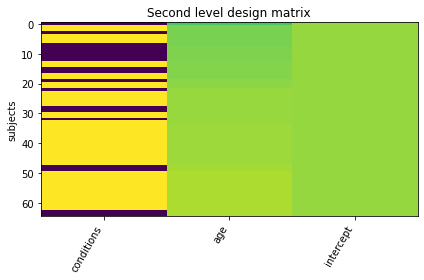

In [7]:
design_matrix = make_second_level_design_matrix(file_id, confounds)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('subjects')
plt.tight_layout()
plt.show()

Second level model estimation
===========================================

In [8]:
second_level_input = r2maps
second_level_model = SecondLevelModel().fit(
        second_level_input, design_matrix=design_matrix)

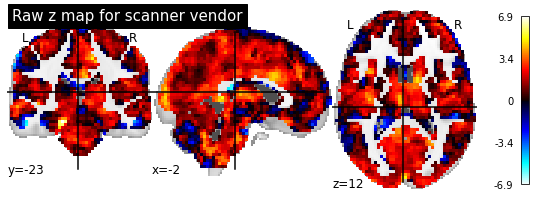

In [9]:
zmap_conditions = second_level_model.compute_contrast(
    'conditions', output_type='z_score')
plotting.plot_stat_map(zmap_conditions, title='Raw z map for scanner vendor')
plotting.show()

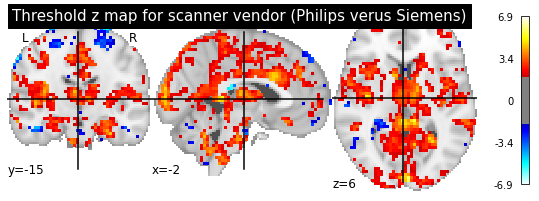

In [10]:
plotting.plot_stat_map(zmap_conditions, threshold=2, title='Threshold z map for scanner vendor (Philips verus Siemens)')
plotting.show()

Bonferroni-corrected, p<0.05 threshold: 4.900


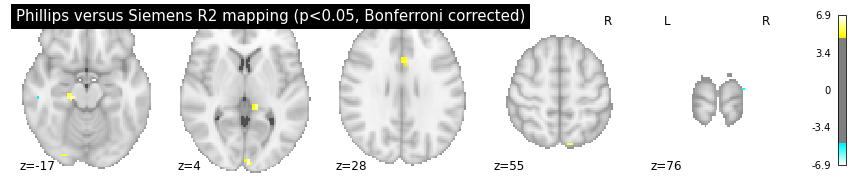

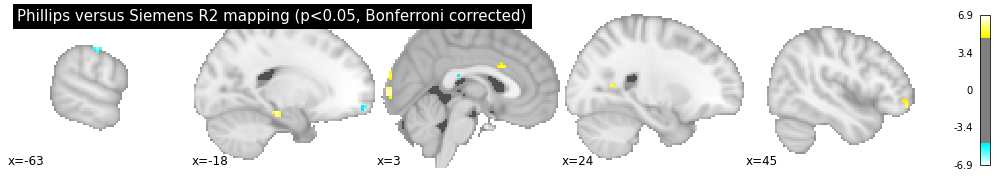

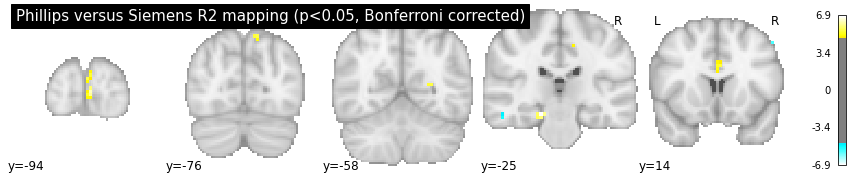

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-18.0,-25.0,-17.0,6.870211,297
1,2,3.0,-97.0,4.0,6.468900,378
2,3,12.0,-34.0,4.0,6.082290,162
3,4,-48.0,-79.0,22.0,5.855748,54
4,5,45.0,50.0,-11.0,5.641820,162
5,6,12.0,-76.0,55.0,5.623978,135
6,7,0.0,-94.0,16.0,5.619492,135
7,8,-21.0,-91.0,-20.0,5.551469,162
8,9,27.0,-58.0,10.0,5.531190,108
9,10,3.0,14.0,28.0,5.527229,270


In [19]:
_, threshold = map_threshold(zmap_conditions, alpha=.05, height_control='bonferroni')
print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_conditions, threshold=threshold, display_mode='z', cut_coords=5,
              title='Phillips versus Siemens R2 mapping (p<0.05, Bonferroni corrected)')
plt.show()

plotting.plot_stat_map(zmap_conditions, threshold=threshold, display_mode='x', cut_coords=5,
              title='Phillips versus Siemens R2 mapping (p<0.05, Bonferroni corrected)')
plt.show()

plotting.plot_stat_map(zmap_conditions, threshold=threshold, display_mode='y', cut_coords=5,
              title='Phillips versus Siemens R2 mapping (p<0.05, Bonferroni corrected)')
plt.show()

get_clusters_table(zmap_conditions, stat_threshold=threshold, cluster_threshold=None)

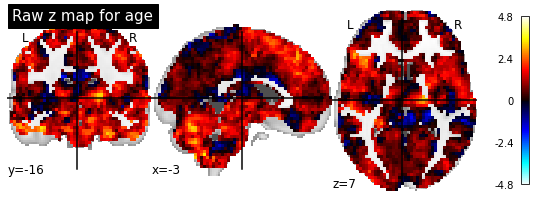

In [15]:
zmap_age = second_level_model.compute_contrast(
    'age', output_type='z_score')
plotting.plot_stat_map(zmap_age, title='Raw z map for age')
plotting.show()

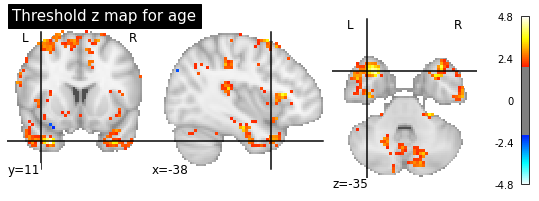

In [16]:
plotting.plot_stat_map(zmap_age, threshold=2, title='Threshold z map for age')
plotting.show()

Bonferroni-corrected, p<0.05 threshold: 4.900


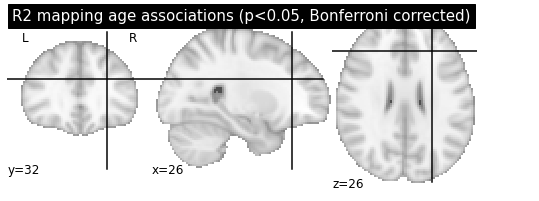

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


In [17]:
_, threshold = map_threshold(zmap_age, alpha=.05, height_control='bonferroni')
print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_age, threshold=threshold, 
              title='R2 mapping age associations (p<0.05, Bonferroni corrected)')
plt.show()

get_clusters_table(zmap_age, stat_threshold=threshold, cluster_threshold=None)